In this notebook we find the optimal magnetic parameters to simulate two skyrmion strings in Co8Zn9Mn3. For this analysis we use three different DMI values such that the helical length is 120 nm. Simulations are done for different magnetic field magnitudes.

# Imports

In [3]:
import numpy as np
import oommfpy as op
import matplotlib.pyplot as plt
from pathlib import Path

import matplotlib.patheffects as PathEffects

# Parameters

Here we just calculate the DMI value or exchange constant, to get a helical length LD of 120 nm in the material

In [338]:
Ms = 4.60545e5
A = 7.875e-12
# A = 6e-12
D = 0.6e-3
LD = 4 * np.pi * A / D

In [242]:
print(LD * 1e9)

125.66370614359175


In [339]:
print((4 * np.pi * A) / (120e-9))

0.0008246680715673208


In [340]:
print(D * (120e-9) / (4 * np.pi))

5.729577951308231e-12


In [344]:
4 * np.pi * (A) / (0.82466801e-3)

1.200000089588518e-07

In [264]:
5 * 2 ** 9

2560

# Averages

For three MuMax3 simulations with different DMI and exchange values, such that the helical length is 120 nm, we will compute the average `mz` value across the sample thickness. For this we use OOMMFPy. We start by looking into the simulation files:

In [351]:
!ls ../sims/mumax3/two_tubes_center_Co8Zn9Mn3/

nohup.out
two_tubes_D_0d6e-3_A_5d7295e-12_LD_120nm
two_tubes_D_0d6e-3_A_5d7295e-12_LD_120nm.go
two_tubes_D_0d6e-3_A_5d7295e-12_LD_120nm.out
two_tubes_D_0d7e-3_A_6d684e-12_LD_120nm
two_tubes_D_0d7e-3_A_6d684e-12_LD_120nm.go
two_tubes_D_0d7e-3_A_6d684e-12_LD_120nm.out
two_tubes_D_0d8246e-3_A_7d875e-12_LD_120nm
two_tubes_D_0d8246e-3_A_7d875e-12_LD_120nm.go


We will save the results of averaging in the `mz_average_by` dictionary, which has 3 entries, one for each simulation. Every simulation relaxes two skyrmion strings at different magnetic field magnitudes. The field is applied in the `-y` direction. We compute the averages for every field:

In [415]:
mz_average_by = {}
mz_average_by['D_0d6e-3_A_5d7295e-12'] = {}
mz_average_by['D_0d7e-3_A_6d684e-12'] = {}
mz_average_by['D_0d8246e-3_A_7d875e-12'] = {}

BASEDIR = Path('../sims/mumax3/two_tubes_center_Co8Zn9Mn3/')
for PARAMS in mz_average_by.keys():
    print(f'Computing for: {PARAMS}')
    # Compute the mz average for every field:
    for by in np.arange(-40, -210, -20):

        FILE = BASEDIR / f'two_tubes_{PARAMS}_LD_120nm.out/m_By_-{abs(by):06d}_mT.ovf'
        if not FILE.exists():
            continue

        # Load data with OOMMFPy
        data = op.MagnetisationData(FILE)
        # Generate the coordinates and magnetisation data:
        data.generate_coordinates()
        data.generate_field()
        # Reshape the mz data into a 3D Numpy array, where the first dimension
        # refers to the z direction (see OOMMF data format)
        mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)

        mz_av = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
        # For every layer perpendicular to z, sum the mz components at the
        # corresponding layer mesh sites:
        for z_idx in range(mz_3d.shape[0]):
            mz_av += mz_3d[z_idx, :, :]

        # Average with the number of z layers
        mz_av /= mz_3d.shape[0]

        # Save into the dictionary:
        mz_average_by[PARAMS][by] = mz_av

Computing for: D_0d6e-3_A_5d7295e-12
Computing for: D_0d7e-3_A_6d684e-12
Computing for: D_0d8246e-3_A_7d875e-12


Now we can plot the results. We save some matplotlib plot arguments here:

In [416]:
im_tubes_args = dict(vmin=-1, vmax=1, origin='lower',
                     extent=np.array([data.xmin, data.xmax, data.ymin, data.ymax]) * 1e9)

In [417]:
PLOTDIR = Path('two_tubes_center_mz_average_By')
PLOTDIR.mkdir(exist_ok=True)

In [435]:
Ms = 4.60545e5
mu0 = 4 * np.pi * 1e-7
for p, PARAMS in enumerate(mz_average_by.keys()):
    magpms = PARAMS.split('_')
    d = float((magpms[1]).replace('d', '.'))
    a = float((magpms[3]).replace('d', '.'))
    BD = (d ** 2) / (Ms * a)
    print(f'D = {d * 1e3:.3f} mJ/m  A = {a * 1e12:.3f} pJ/m^2   µ0 H_D = {BD * 0.5:.4f}')

D = 0.600 mJ/m  A = 5.729 pJ/m^2   µ0 H_D = 0.0682
D = 0.700 mJ/m  A = 6.684 pJ/m^2   µ0 H_D = 0.0796
D = 0.825 mJ/m  A = 7.875 pJ/m^2   µ0 H_D = 0.0937


In [2]:
import math

A = 5.729e-12
mu0 = 4 * math.pi * 1e-7
Ms = 4.60545e5

print(math.sqrt(2 * A / (mu0 * Ms ** 2)))

6.556580614024033e-09


We plot every simulation in a different column and the `mz` averages at different fields in different rows:

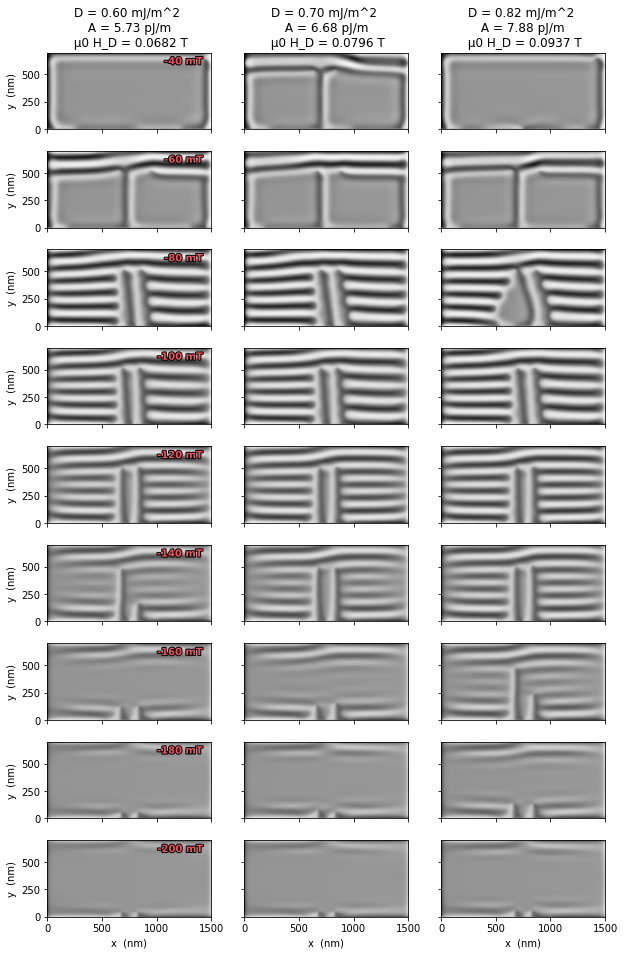

In [430]:
f, axs = plt.subplots(figsize=(10, 16), ncols=3, nrows=9, sharex=True, sharey=True)

for p, PARAMS in enumerate(mz_average_by.keys()):
    for b, by in enumerate(np.arange(-40, -210, -20)):
        
        if by in mz_average_by[PARAMS].keys():
            axs[b][p].imshow(mz_average_by[PARAMS][by], cmap='Greys', **im_tubes_args)
        # axs[b][p].set_xlabel('x  (nm)')
        # axs[b][p].set_ylabel('y  (nm)')
        # axs[b][p].set_title(f'Field: {by} mT')

        if p == 0:
            t = axs[b][p].text(0.95, 0.95, f'{by} mT', ha='right', va='top',
                               transform=axs[b][p].transAxes, 
                               rotation=0, color='#EB5660', fontweight='bold')

            t.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
            
            axs[b][p].set_ylabel('y  (nm)')
            
        if b == 8:
            axs[b][p].set_xlabel('x  (nm)')
            
        if b == 0:
            magpms = PARAMS.split('_')
            Ms = 4.60545e5
            d = float((magpms[1]).replace('d', '.'))
            a = float((magpms[3]).replace('d', '.'))
            BD = (d ** 2) / (2 * Ms * a)
            axs[b][p].set_title(f'D = {d * 1e3:.2f} mJ/m^2 \n A = {a * 1e12:.2f} pJ/m \n µ0 H_D = {BD:.4f} T')

# plt.tight_layout()
plt.savefig(PLOTDIR / f'mz_average_By_{by}.png', dpi=200, bbox_inches='tight')
plt.show()

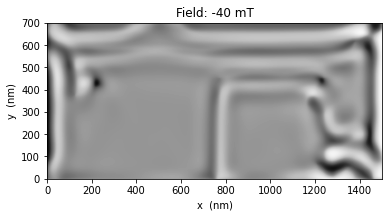

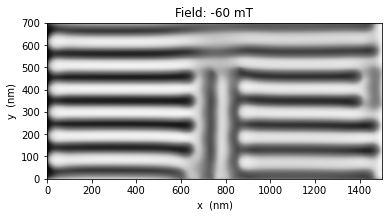

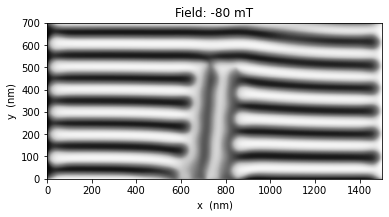

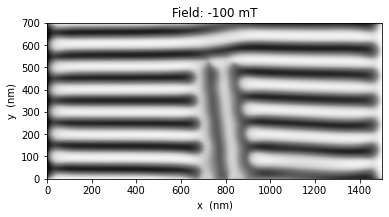

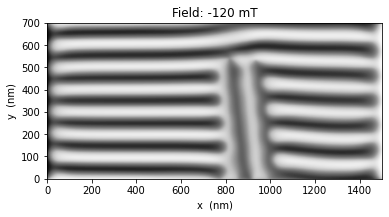

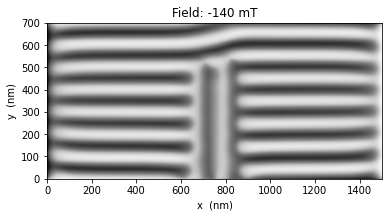

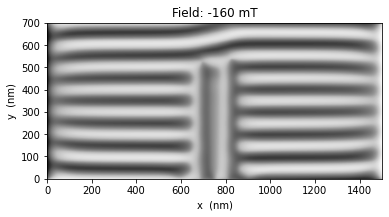

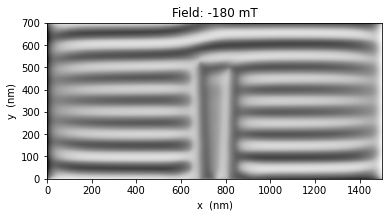

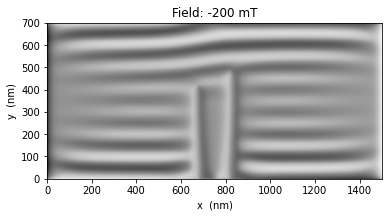

In [73]:
for by in np.arange(-40, -210, -20):
    f, ax = plt.subplots()
    ax.imshow(mz_average_by[by], cmap='Greys', **im_tubes_args)
    ax.set_xlabel('x  (nm)')
    ax.set_ylabel('y  (nm)')
    ax.set_title(f'Field: {by} mT')
    plt.savefig(PLOTDIR / f'mz_average_By_{by}.png', dpi=200, bbox_inches='tight')
    plt.show()

In [54]:
by = -60
data = op.MagnetisationData(f'../sims/mumax3/skyrmion_conical/two_sk_tubes_center_no-helix_Co8Zn9Mn3.out/m_By_-{abs(by):06d}_mT.ovf')
data.generate_coordinates()
data.generate_field()
my_3d = data.my.reshape(data.nz, data.ny, data.nx)
mz_3d = data.mz.reshape(data.nz, data.ny, data.nx)
print(my_3d.shape)

(40, 140, 300)


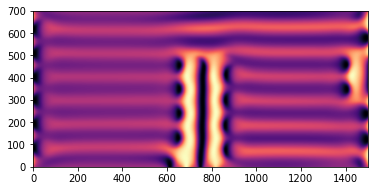

In [56]:
plt.imshow(my_3d[20, :, :], cmap='magma', **im_tubes_args)

In [57]:
mz_average = np.zeros((mz_3d.shape[1], mz_3d.shape[2]))
for z_idx in range(mz_3d.shape[0]):
    mz_average += mz_3d[z_idx, :, :]
    
mz_average /= mz_3d.shape[0]

# 3D Visualisation

We can visualize some of the results using PyVista:

In [1]:
import pyvista as pv

In [5]:
by = -60
data = op.MagnetisationData(f'../sims/mumax3/skyrmion_conical/two_sk_tubes_center_no-helix_Co8Zn9Mn3.out/m_By_-{abs(by):06d}_mT.ovf')
data.generate_coordinates()
data.generate_field()

grid = pv.RectilinearGrid(*(d * 1e9 for d in data.grid))

grid.cell_arrays.update(dict(my=data.my))
grid.cell_arrays.update(dict(mz=data.mz))
grid.cell_arrays.update(dict(mx=data.mx))

grid = grid.cell_data_to_point_data()
grid.point_data.update(dict(m_vec=np.column_stack((grid.get_array('mx'),
                                                   grid.get_array('my'),
                                                   grid.get_array('mz')))))

contours = grid.contour(scalars='my', isosurfaces=[0])

In [6]:
contours

PolyData (0x7fd3510aed60)
  N Cells:	264460
  N Points:	136976
  X Bounds:	0.000e+00, 1.500e+03
  Y Bounds:	0.000e+00, 7.000e+02
  Z Bounds:	0.000e+00, 2.000e+02
  N Arrays:	4

In [7]:
grid.slice

<bound method DataSetFilters.slice of RectilinearGrid (0x7fd3510ae700)
  N Cells:	1680000
  N Points:	1740081
  X Bounds:	0.000e+00, 1.500e+03
  Y Bounds:	0.000e+00, 7.000e+02
  Z Bounds:	0.000e+00, 2.000e+02
  Dimensions:	301, 141, 41
  N Arrays:	4
>

In [206]:
# Controlling the text properties
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    n_labels=3,
    color='black',
    fmt="%.1f",
    font_family="arial",
)

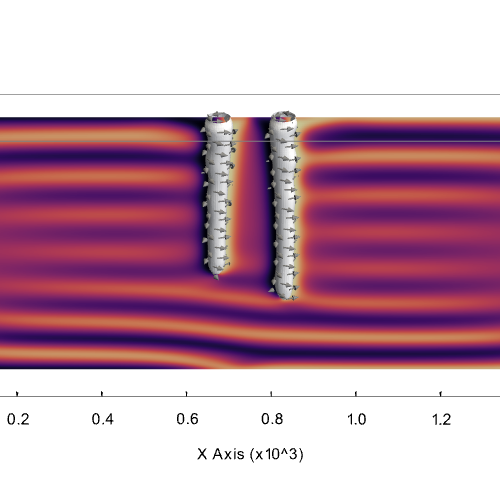

In [235]:
p = pv.Plotter(off_screen=False, notebook=True, window_size=[600, 400])

# box = pyvista.Box([-0.03, 0.03, -0.03, 0.03, -0.03, 0.03])
# p.add_mesh(box.outline(), color='black', opacity=1, line_width=0.6)

p.show_bounds(grid, color='black', location='outer', fmt='%.2f', font_family='arial')

p.add_mesh(contours.smooth(n_iter=100), opacity=1, style='surface', scalars='my', clim=[-1, 1],
           cmap='RdBu', show_scalar_bar=False, 
           # smooth_shading=True, lighting=True, specular=0.6, specular_power=10, ambient=0.
           )
p.add_mesh(grid.slice(normal='z'), opacity=1, style='surface', scalars='mz', cmap='magma', 
           show_scalar_bar=False, clim=[-1, 1], scalar_bar_args=sargs)
p.add_mesh(grid.outline(), opacity=1, style='surface', color='grey')

arrows = contours.glyph(scale=False, factor=30, orient="m_vec",
                        tolerance=0.05, geom=pv.Arrow(tip_length=0.5, tip_radius=0.2)
                        )
p.add_mesh(arrows, color='grey')

light = pv.Light(position=(1, 0, -1), light_type='scene light', intensity=0.5)
p.add_light(light)

p.set_background('white')
p.view_isometric()
# p.camera.SetWindowCenter(0., -0.09)
p.camera.zoom(1.5)
# p.camera.zoom(2.)
# p.camera.SetParallelProjection(1)
p.camera.azimuth = -135
p.camera.elevation = -90
p.show(jupyter_backend='static', window_size=[500, 500], # screenshot='test.png'
       )

In [267]:
by = -120
data = op.MagnetisationData(f'../sims/mumax3/two_tubes_center_Co8Zn9Mn3/two_tubes_D_0d7e-3_A_6d684e-12_LD_120nm.out/m_By_-{abs(by):06d}_mT.ovf')
data.generate_coordinates()
data.generate_field()

grid = pv.RectilinearGrid(*(d * 1e9 for d in data.grid))

grid.cell_arrays.update(dict(my=data.my))
grid.cell_arrays.update(dict(mz=data.mz))
grid.cell_arrays.update(dict(mx=data.mx))

grid = grid.cell_data_to_point_data()
grid.point_arrays.update(dict(m_vec=np.column_stack((grid.get_array('mx'),
                                                     grid.get_array('my'),
                                                     grid.get_array('mz')))))

contours = grid.contour(scalars='my', isosurfaces=[0])

In [271]:
pv.global_theme.axes.show = True

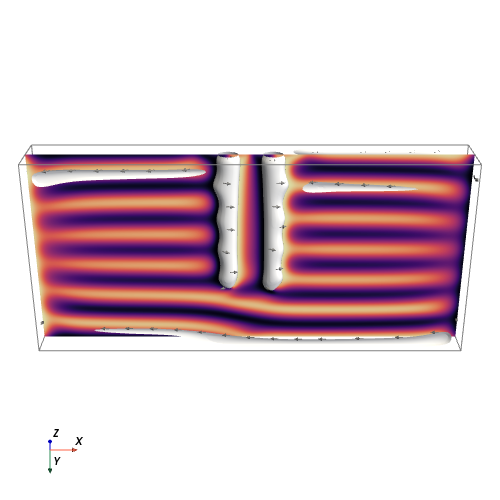

In [350]:
p = pv.Plotter(off_screen=False, notebook=True, window_size=[600, 400])

# box = pyvista.Box([-0.03, 0.03, -0.03, 0.03, -0.03, 0.03])
# p.add_mesh(box.outline(), color='black', opacity=1, line_width=0.6)

# p.show_bounds(grid, color='black', location='outer', fmt='%.2f', font_family='arial')

p.add_mesh(contours.smooth(n_iter=100), opacity=1, style='surface', scalars='my', clim=[-1, 1],
           cmap='RdBu', show_scalar_bar=False, 
           smooth_shading=True, # lighting=True, specular=0.6, specular_power=10, ambient=0.
           )
p.add_mesh(grid.slice(normal='z'), opacity=1, style='surface', scalars='mz', cmap='magma', 
           show_scalar_bar=False, clim=[-1, 1], scalar_bar_args=sargs)
p.add_mesh(grid.outline(), opacity=1, style='surface', color='grey')

arrows = contours.glyph(scale=False, factor=30, orient="m_vec",
                        tolerance=0.05, geom=pv.Arrow(tip_length=0.5, tip_radius=0.2)
                        )
p.add_mesh(arrows, color='grey')

light = pv.Light(position=(1, 0, -0.8), light_type='scene light', intensity=0.5)
p.add_light(light)

p.set_background('white')
p.view_isometric()
# p.camera.SetWindowCenter(0., -0.09)
p.camera.zoom(1.)
# p.camera.zoom(2.)
# p.camera.SetParallelProjection(1)

# p.camera.azimuth = -135
# p.camera.roll = 180
# p.camera.elevation = -30

p.camera_position = 'xz'
# p.camera.azimuth = 10
p.camera.elevation = -65

p.add_axes(color='black', box=False, line_width=1)
p.show(jupyter_backend='static', window_size=[500, 500], # screenshot='test.png'
       )